# Comparative LCA: OFMSW

In [1]:
import swolfpy as sp
import swolfpy_inputdata as spid
import swolfpy_processmodels as sppm

import brightway2 as bw2
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
import datetime
import os
import platform


plt.rcParams["axes.formatter.limits"] = [-3, 4]
plt.rcParams["axes.formatter.use_mathtext"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = '13'

### SwolfPy version used to produced the results:

In [2]:
pd.DataFrame({'Version': [sp.__version__, sppm.__version__, spid.__version__]},
             index=['swolfpy', 'swolfpy_processmodels', 'swolfpy_inputdata'])

,Version
swolfpy,0.2.4
swolfpy_processmodels,0.1.9
swolfpy_inputdata,0.2.4


### System info

In [3]:
pd.DataFrame({'info': [platform.platform(),
                       platform.processor(),
                       os.cpu_count()]},
             index=['Platform', 'Processor', 'CPU_count'])

,info
Platform,Windows-10-10.0.19041-SP0
Processor,"Intel64 Family 6 Model 158 Stepping 9, Genuine..."
CPU_count,8


## Create project

In [4]:
project_name = 'OFMSW'
technosphere = sp.Technosphere(project_name)
common_data = spid.CommonData()
ProcessMetaData = sppm.ProcessModelsMetaData.ProcessModelsMetaData

In [5]:
# Treatment processes
Treatment_processes = {}
Treatment_processes['LF'] = {'input_type':ProcessMetaData['LF']['InputType'] , 'model':sppm.LF()}
Treatment_processes['Composting'] = {'input_type':ProcessMetaData['Comp']['InputType'] , 'model':sppm.Comp()}
Treatment_processes['AD'] = {'input_type':ProcessMetaData['AD']['InputType'] , 'model':sppm.AD()}
Treatment_processes['Home_Comp'] = {'input_type':ProcessMetaData['HC']['InputType'] , 'model':sppm.HC()}
Treatment_processes['WTE'] = {'input_type':ProcessMetaData['WTE']['InputType'] , 'model':sppm.WTE()}
Treatment_processes['SS_MRF'] = {'input_type':ProcessMetaData['SS_MRF']['InputType'] , 'model':sppm.SS_MRF()}
Treatment_processes['Reprocessing'] = {'input_type':ProcessMetaData['Reproc']['InputType'] , 'model':sppm.Reproc()}

In [6]:
# Distance
Processes = ['LF', 'Composting', 'AD', 'Home_Comp', 'WTE',
             'SS_MRF', 'Reprocessing', 'Collection']
data = sppm.Distance.create_distance_table(process_names=Processes,
                                           transport_modes=['Heavy Duty Truck'],
                                           default_dist=30)
data['Heavy Duty Truck']['Collection']['Home_Comp'] = 0

distance = sppm.Distance(data)          
data['Heavy Duty Truck']

,LF,Composting,AD,Home_Comp,WTE,SS_MRF,Reprocessing,Collection
LF,NaN,30.0,30.0,30.0,30.0,30.0,30.0,30.0
Composting,NaN,NaN,30.0,30.0,30.0,30.0,30.0,30.0
AD,NaN,NaN,NaN,30.0,30.0,30.0,30.0,30.0
Home_Comp,NaN,NaN,NaN,NaN,30.0,30.0,30.0,0.0
WTE,NaN,NaN,NaN,NaN,NaN,30.0,30.0,30.0
SS_MRF,NaN,NaN,NaN,NaN,NaN,NaN,30.0,30.0
Reprocessing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0
Collection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Collection_processes:
# Only include one single family sector wih residual waste collection
Collection_scheme = sppm.SF_Col.scheme()
Collection_scheme[('RWC', 'SSYW', 'SSR')] = 0.5
Collection_scheme[('RWC', 'N/A', 'N/A')] = 0.5

Collection_processes = {}
Collection_processes['Collection'] = {'input_type': [],
                                      'model': sppm.SF_Col('Collection', Collection_scheme,
                                                           Treatment_processes=Treatment_processes,
                                                           Distance=distance)}

# Home composting
Collection_processes['Collection']['model'].InputData.Col['HC_partic']['amount'] = 0

In [8]:
# Revise composition

Gen_Comp = Collection_processes['Collection']['model'].process_data

# Yard Waste
Tot_yardwaste = Gen_Comp['Comp'][0:3].sum()
Gen_Comp.loc['Yard_Trimmings_Leaves', 'Comp'] = Tot_yardwaste  * 0.2
Gen_Comp.loc['Yard_Trimmings_Grass', 'Comp'] = Tot_yardwaste  * 0.5
Gen_Comp.loc['Yard_Trimmings_Branches', 'Comp'] = Tot_yardwaste  * 0.3

# Food Waste
Tot_foodwaste = Gen_Comp['Comp'][3:5].sum()
Gen_Comp.loc['Food_Waste_Vegetable', 'Comp'] = Tot_foodwaste  * 0.667
Gen_Comp.loc['Food_Waste_Non_Vegetable', 'Comp'] = Tot_foodwaste  * 0.333


assert Collection_processes['Collection']['model'].process_data['Comp'].sum() == 1

In [9]:
start = time()
demo = sp.Project(project_name, common_data, Treatment_processes, distance, Collection_processes, technosphere)
demo.init_project()
demo.write_project()
demo.group_exchanges()
print("Time for writing the project: {} second".format(round(time()-start)))

Biosphere database already present!!! No setup is needed
Vacuuming database 
Vacuuming database 


Writing activities to SQLite3 database:



                ####
                ++++++  Writing the Technosphere
                


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:35:43
  Finished: 12/19/2021 14:35:59
  Total time elapsed: 00:00:15
  CPU %: 39.50
  Memory %: 1.35


Writing activities to SQLite3 database:



              ####
              ++++++ Initializing the LF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:36:00
  Finished: 12/19/2021 14:36:00
  Total time elapsed: 00:00:00
  CPU %: 100.80
  Memory %: 1.36

              ####
              ++++++ Initializing the Composting
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:36:00
  Finished: 12/19/2021 14:36:00
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 1.36

              ####
              ++++++ Initializing the AD
              


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:36:00
  Finished: 12/19/2021 14:36:00
  Total time elapsed: 00:00:00
  CPU %: 195.30
  Memory %: 1.36

              ####
              ++++++ Initializing the Home_Comp
              


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:36:00
  Finished: 12/19/2021 14:36:00
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 1.36

              ####
              ++++++ Initializing the WTE
              


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:36:01
  Finished: 12/19/2021 14:36:01
  Total time elapsed: 00:00:00
  CPU %: 104.20
  Memory %: 1.36

              ####
              ++++++ Initializing the SS_MRF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:36:01
  Finished: 12/19/2021 14:36:01
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 1.36

              ####
              ++++++ Initializing the Reprocessing
              


Writing activities to SQLite3 database:
0% [###############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:36:01
  Finished: 12/19/2021 14:36:01
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 1.36

              ####
              ++++++ Initializing the Collection
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:36:01
  Finished: 12/19/2021 14:36:01
  Total time elapsed: 00:00:00
  CPU %: 104.20
  Memory %: 1.36


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the LF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:36:01
  Finished: 12/19/2021 14:36:02
  Total time elapsed: 00:00:01
  CPU %: 43.30
  Memory %: 1.37

                  ####
                  ++++++ Writing the Composting_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:36:03
  Finished: 12/19/2021 14:36:03
  Total time elapsed: 00:00:00
  CPU %: 50.40
  Memory %: 1.39

              ####
              ++++++ Writing the Composting
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:36:03
  Finished: 12/19/2021 14:36:03
  Total time elapsed: 00:00:00
  CPU %: 42.80
  Memory %: 1.39

                  ####
                  ++++++ Writing the AD_product
                  


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:36:03
  Finished: 12/19/2021 14:36:03
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 1.39

              ####
              ++++++ Writing the AD
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:36:03
  Finished: 12/19/2021 14:36:04
  Total time elapsed: 00:00:00
  CPU %: 63.90
  Memory %: 1.39

              ####
              ++++++ Writing the Home_Comp
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:36:04
  Finished: 12/19/2021 14:36:04
  Total time elapsed: 00:00:00
  CPU %: 62.50
  Memory %: 1.40

                  ####
                  ++++++ Writing the WTE_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:36:04
  Finished: 12/19/2021 14:36:04
  Total time elapsed: 00:00:00
  CPU %: 99.70
  Memory %: 1.41


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the WTE
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:36:05
  Finished: 12/19/2021 14:36:05
  Total time elapsed: 00:00:00
  CPU %: 47.50
  Memory %: 1.41

                  ####
                  ++++++ Writing the SS_MRF_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:36:06
  Finished: 12/19/2021 14:36:06
  Total time elapsed: 00:00:00
  CPU %: 63.60
  Memory %: 1.42


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the SS_MRF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:36:07
  Finished: 12/19/2021 14:36:07
  Total time elapsed: 00:00:00
  CPU %: 54.50
  Memory %: 1.43

              ####
              ++++++ Writing the Reprocessing
              


0% [###############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:36:07
  Finished: 12/19/2021 14:36:07
  Total time elapsed: 00:00:00
  CPU %: 66.50
  Memory %: 1.43

                  ####
                  ++++++ Writing the Collection_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:36:08
  Finished: 12/19/2021 14:36:08
  Total time elapsed: 00:00:00
  CPU %: 57.10
  Memory %: 1.44


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the Collection
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/19/2021 14:36:09
  Finished: 12/19/2021 14:36:09
  Total time elapsed: 00:00:00
  CPU %: 57.30
  Memory %: 1.45

                  Grouping the exchanges with parameters in Database LF
                  

                  Grouping the exchanges with parameters in Database Composting
                  

                  Grouping the exchanges with parameters in Database AD
                  

                  Grouping the exchanges with parameters in Database Home_Comp
                  

                  Grouping the exchanges with parameters in Database WTE
                  

                  Grouping the exchanges with parameters in Database SS_MRF
                  

                  Grouping the exchanges with parameters in Database Reprocessing
                  

                  Grouping the exchanges with parameters in Database Collection
                  
Time for writing the project: 80 second


In [10]:
demo.parameters.default_parameters_list()

[{'name': 'frac_of_Other_Residual_from_Composting_to_LF', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_Composting_to_WTE', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_AD_to_LF', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_AD_to_WTE', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_SS_MRF_to_LF', 'amount': 0.5},
 {'name': 'frac_of_Other_Residual_from_SS_MRF_to_WTE', 'amount': 0.5},
 {'name': 'frac_of_RWC_from_Collection_to_LF', 'amount': 0.5},
 {'name': 'frac_of_RWC_from_Collection_to_WTE', 'amount': 0.5},
 {'name': 'frac_of_SSO_from_Collection_to_Composting', 'amount': 0.5},
 {'name': 'frac_of_SSO_from_Collection_to_AD', 'amount': 0.5},
 {'name': 'frac_of_MRDO_from_Collection_to_LF', 'amount': 0.5},
 {'name': 'frac_of_MRDO_from_Collection_to_WTE', 'amount': 0.5}]

In [11]:
new_parameters = [{'name': 'frac_of_Other_Residual_from_Composting_to_LF', 'amount': 1},
                 {'name': 'frac_of_Other_Residual_from_Composting_to_WTE', 'amount': 0},
                 {'name': 'frac_of_Other_Residual_from_AD_to_LF', 'amount': 1},
                 {'name': 'frac_of_Other_Residual_from_AD_to_WTE', 'amount': 0.0},
                 {'name': 'frac_of_Other_Residual_from_SS_MRF_to_LF', 'amount': 1},
                 {'name': 'frac_of_Other_Residual_from_SS_MRF_to_WTE', 'amount': 0},
                 {'name': 'frac_of_RWC_from_Collection_to_LF', 'amount': 1},
                 {'name': 'frac_of_RWC_from_Collection_to_WTE', 'amount': 0},
                 {'name': 'frac_of_SSO_from_Collection_to_Composting', 'amount': 1},
                 {'name': 'frac_of_SSO_from_Collection_to_AD', 'amount': 0},
                 {'name': 'frac_of_MRDO_from_Collection_to_LF', 'amount': 1},
                 {'name': 'frac_of_MRDO_from_Collection_to_WTE', 'amount': 0}]

In [12]:
start = time()
demo.update_parameters(new_parameters)
print("Time for updating the parameters: {} second".format(round(time()-start)))

Time for updating the parameters: 10 second


## SSYW

In [13]:
# SSYW composition
Collection_scheme = sppm.SF_Col.scheme()
Collection_scheme[('RWC', 'SSYW', 'N/A')] = 1
demo.Treatment_processes['Collection']['model'].col_schm = Collection_scheme 
demo.Treatment_processes['Collection']['model'].calc()
massflows = demo.Treatment_processes['Collection']['model'].col_massflow
SSYW_Comp = massflows['SSYW'] / sum(massflows['SSYW'])
SSYW_Comp=SSYW_Comp[SSYW_Comp>0]
SSYW_Comp

Yard_Trimmings_Leaves      0.2
Yard_Trimmings_Grass       0.5
Yard_Trimmings_Branches    0.3
Name: SSYW, dtype: float64

In [14]:
SSYW_Fraction = SSYW_Comp.to_dict()
SSYW_processes = ['LF', 'Composting','AD', 'Home_Comp', 'WTE']
SSYW_functional_units = []

for p in SSYW_processes:
    input_dict = {p: {}}
    for f in SSYW_Fraction:
        input_dict[p][f] = SSYW_Fraction[f]
    demo.create_scenario(input_dict, f'SSYW_to_{p}')
    SSYW_functional_units.append({('waste', f'SSYW_to_{p}'): 1})
SSYW_functional_units

[{('waste', 'SSYW_to_LF'): 1},
 {('waste', 'SSYW_to_Composting'): 1},
 {('waste', 'SSYW_to_AD'): 1},
 {('waste', 'SSYW_to_Home_Comp'): 1},
 {('waste', 'SSYW_to_WTE'): 1}]

In [15]:
[x for x in bw2.methods if 'TRACI' in str(x)]

[('TRACI (obsolete)', 'environmental impact', 'acidification'),
 ('TRACI (obsolete)', 'environmental impact', 'ecotoxicity'),
 ('TRACI (obsolete)', 'environmental impact', 'eutrophication'),
 ('TRACI (obsolete)', 'environmental impact', 'global warming'),
 ('TRACI (obsolete)', 'environmental impact', 'ozone depletion'),
 ('TRACI (obsolete)', 'environmental impact', 'photochemical oxidation'),
 ('TRACI (obsolete)', 'human health', 'carcinogenics'),
 ('TRACI (obsolete)', 'human health', 'non-carcinogenics'),
 ('TRACI (obsolete)', 'human health', 'respiratory effects, average'),
 ('TRACI (2.1) SwolfPy', 'environmental impact', 'acidification'),
 ('TRACI (2.1) SwolfPy', 'environmental impact', 'eutrophication')]

In [16]:
impact_methods = [('IPCC 2013', 'climate change', 'GWP 100a'),
                  ('TRACI (2.1) SwolfPy', 'environmental impact', 'acidification'),
                  #('TRACI (obsolete)', 'environmental impact', 'photochemical oxidation'),
                  ('TRACI (2.1) SwolfPy', 'environmental impact', 'eutrophication'),
                  ('CML (v4.4) SwolfPy', 'resources', 'depletion of abiotic resources - elements, ultimate reserves'),
                  ('cumulative energy demand', 'fossil','non-renewable energy resources, fossil'),
                    ('SwolfPy_Total_Cost', 'SwolfPy')]

In [17]:
SSYW_impacts = demo.setup_LCA(name='SSYW',
                               functional_units=SSYW_functional_units,
                               impact_methods = impact_methods)
SSYW_impacts.sort_values(by=SSYW_impacts.columns[0], inplace=True)

SSYW_impacts.columns = ['A: GWP (kgCO2 e)', 'B; Acidification (kgSO2 e)', 'C: Eutrophication (kgN e)',
                        'D: ADP (kg antimony e)', 'E: CED (MJ e)', 'G: Cost ($)']
SSYW_impacts.index = [eval(i)[1].replace('SSYW_to_', '') for i in SSYW_impacts.index]
SSYW_impacts

,A: GWP (kgCO2 e),B; Acidification (kgSO2 e),C: Eutrophication (kgN e),D: ADP (kg antimony e),E: CED (MJ e),G: Cost ($)
WTE,-450.209296,-2.897109,-1.113946,-0.000040,-5859.234223,59.130024
LF,-307.258814,-0.334466,-0.074430,-0.000002,-640.265876,14.523590
AD,-20.981287,1.435275,1.648425,-0.000180,-2676.544170,71.207584
Composting,-5.036420,1.217627,1.859115,-0.000262,-1699.356771,29.830824
Home_Comp,29.872371,1.164983,1.885280,-0.000287,-2229.270897,15.486973


c:\users\msardar2\.conda\envs\dev\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning:


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.



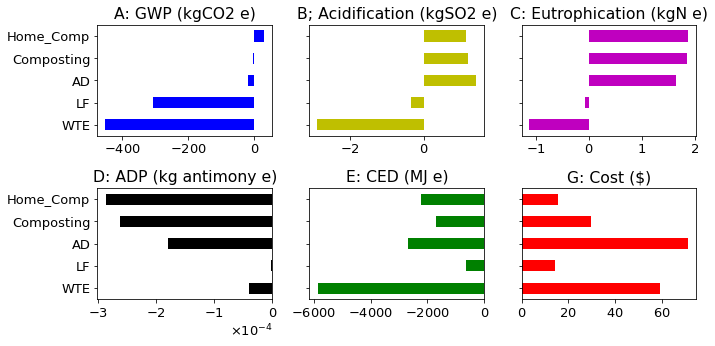

In [18]:
def plot_results(data, figname):
    fig, axes = plt.subplots(2, 3, figsize=(10,5), sharey=True)
    data.iloc[:, 0].plot(kind='barh', ax=axes[0][0], color='b', title=data.columns[0])
    data.iloc[:, 1].plot(kind='barh', ax=axes[0][1], color='y', title=data.columns[1])
    data.iloc[:, 2].plot(kind='barh', ax=axes[0][2], color='m', title=data.columns[2])
    data.iloc[:, 3].plot(kind='barh', ax=axes[1][0], color='k', title=data.columns[3])
    data.iloc[:, 4].plot(kind='barh', ax=axes[1][1], color='g', title=data.columns[4])
    data.iloc[:, 5].plot(kind='barh', ax=axes[1][2], color='r', title=data.columns[5])
    axes[1][0].ticklabel_format(axis='x', style='sci', scilimits=(-3,4), useMathText=True)
    fig.tight_layout()
    fig.savefig(figname, dpi=600)    
        
    
plot_results(SSYW_impacts, 'SSYW')

## SSO

In [19]:
# SSO composition
Collection_scheme = sppm.SF_Col.scheme()
Collection_scheme[('RWC', 'SSO', 'N/A')] = 1
demo.Treatment_processes['Collection']['model'].col_schm = Collection_scheme 
demo.Treatment_processes['Collection']['model'].calc()
massflows = demo.Treatment_processes['Collection']['model'].col_massflow
SSO_Comp = massflows['SSO'] / sum(massflows['SSO'])
SSO_Comp=SSO_Comp[SSO_Comp>0]
SSO_Comp

Yard_Trimmings_Leaves       0.115307
Yard_Trimmings_Grass        0.288267
Yard_Trimmings_Branches     0.172960
Food_Waste_Vegetable        0.282452
Food_Waste_Non_Vegetable    0.141014
Name: SSO, dtype: float64

In [20]:
SSO_Fraction = SSO_Comp.to_dict()
SSO_processes = ['LF', 'Composting', 'AD', 'Home_Comp', 'WTE']
SSO_functional_units = []

for p in SSO_processes:
    input_dict = {p: {}}
    for f in SSO_Fraction:
        input_dict[p][f] = SSO_Fraction[f]
    demo.create_scenario(input_dict,f'SSO_to_{p}')
    SSO_functional_units.append({('waste', f'SSO_to_{p}'): 1})
SSO_functional_units

[{('waste', 'SSO_to_LF'): 1},
 {('waste', 'SSO_to_Composting'): 1},
 {('waste', 'SSO_to_AD'): 1},
 {('waste', 'SSO_to_Home_Comp'): 1},
 {('waste', 'SSO_to_WTE'): 1}]

In [21]:
SSO_impacts = demo.setup_LCA(name='SSO',
                             functional_units=SSO_functional_units,
                             impact_methods = impact_methods)
SSO_impacts.sort_values(by=SSO_impacts.columns[0], inplace=True)

SSO_impacts.columns = ['A: GWP (kgCO2 e)', 'B; Acidification (kgSO2 e)', 'C: Eutrophication (kgN e)',
                        'D: ADP (kg antimony e)', 'E: CED (MJ e)', 'G: Cost ($)']
SSO_impacts.index = [eval(i)[1].replace('SSO_to_', '') for i in SSO_impacts.index]
SSO_impacts

,A: GWP (kgCO2 e),B; Acidification (kgSO2 e),C: Eutrophication (kgN e),D: ADP (kg antimony e),E: CED (MJ e),G: Cost ($)
WTE,-317.671803,-2.045733,-0.792443,-0.000027,-4155.390821,67.046248
AD,-70.337552,0.930667,1.050344,-0.000156,-2883.324925,61.568627
LF,-51.661213,-0.452803,-0.120330,-0.000003,-863.116797,15.906287
Composting,10.914371,0.935298,1.196264,-0.000170,-1181.267807,29.946526
Home_Comp,45.354744,0.879714,1.204501,-0.000188,-1577.726028,15.486973


c:\users\msardar2\.conda\envs\dev\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning:


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.



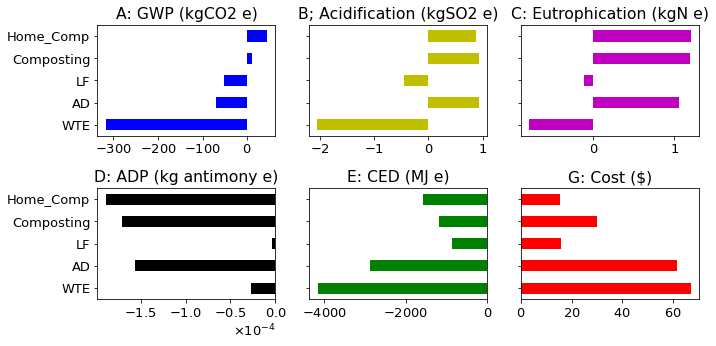

In [22]:
plot_results(SSO_impacts, 'SSO')

## SSO (Only Food Waste)

In [23]:
# SSO composition
Collection_scheme = sppm.SF_Col.scheme()
Collection_scheme[('RWC', 'SSO', 'N/A')] = 1
demo.Treatment_processes['Collection']['model'].col_schm = Collection_scheme 

demo.Treatment_processes['Collection']['model'].process_data['SSO'] = 0
SSO_index = list(demo.Treatment_processes['Collection']['model'].process_data.columns).index('SSO')
demo.Treatment_processes['Collection']['model'].process_data.iloc[3:5, SSO_index] = 0.60


demo.Treatment_processes['Collection']['model'].calc()
massflows = demo.Treatment_processes['Collection']['model'].col_massflow
SSO_FW_Comp = massflows['SSO'] / sum(massflows['SSO'])
SSO_FW_Comp=SSO_FW_Comp[SSO_FW_Comp>0]
SSO_FW_Comp

Food_Waste_Vegetable        0.667
Food_Waste_Non_Vegetable    0.333
Name: SSO, dtype: float64

In [24]:
SSO_FW_Fraction = SSO_FW_Comp.to_dict()
SSO_FW_processes = ['LF', 'Composting', 'AD', 'Home_Comp', 'WTE']
SSO_FW_functional_units = []

for p in SSO_FW_processes:
    input_dict = {p: {}}
    for f in SSO_FW_Fraction:
        input_dict[p][f] = SSO_FW_Fraction[f]
    demo.create_scenario(input_dict,f'SSO_FW_to_{p}')
    SSO_FW_functional_units.append({('waste', f'SSO_FW_to_{p}'): 1})
SSO_FW_functional_units

[{('waste', 'SSO_FW_to_LF'): 1},
 {('waste', 'SSO_FW_to_Composting'): 1},
 {('waste', 'SSO_FW_to_AD'): 1},
 {('waste', 'SSO_FW_to_Home_Comp'): 1},
 {('waste', 'SSO_FW_to_WTE'): 1}]

In [25]:
SSO_FW_impacts = demo.setup_LCA(name='SSO_FW',
                             functional_units=SSO_FW_functional_units,
                             impact_methods = impact_methods)
SSO_FW_impacts.sort_values(by=SSO_FW_impacts.columns[0], inplace=True)

SSO_FW_impacts.columns = ['A: GWP (kgCO2 e)', 'B; Acidification (kgSO2 e)', 'C: Eutrophication (kgN e)',
                        'D: ADP (kg antimony e)', 'E: CED (MJ e)', 'G: Cost ($)']
SSO_FW_impacts.index = [eval(i)[1].replace('SSO_FW_to_', '') for i in SSO_FW_impacts.index]
SSO_FW_impacts

,A: GWP (kgCO2 e),B; Acidification (kgSO2 e),C: Eutrophication (kgN e),D: ADP (kg antimony e),E: CED (MJ e),G: Cost ($)
AD,-137.534381,0.243660,0.236078,-0.000123,-3164.849838,48.445526
WTE,-137.226662,-0.886615,-0.354728,-0.000010,-1835.667896,77.823914
Composting,32.630815,0.550917,0.293815,-0.000046,-475.907889,30.104052
Home_Comp,66.433454,0.491331,0.277646,-0.000055,-690.670586,15.486973
LF,296.325970,-0.613914,-0.182821,-0.000006,-1166.520560,17.788782


c:\users\msardar2\.conda\envs\dev\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning:


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.



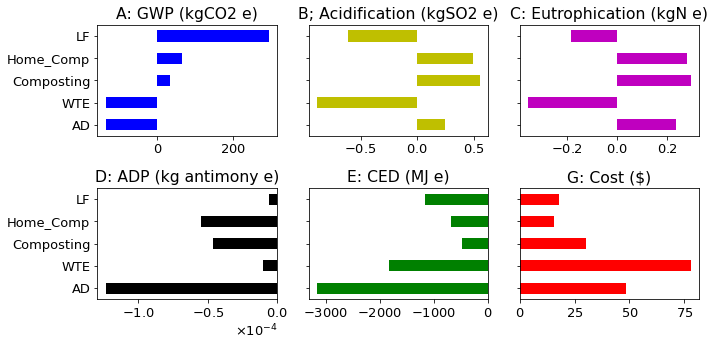

In [26]:
plot_results(SSO_FW_impacts, 'SSO_FW')

## Organics

In [27]:
functional_units = []
for p in ['LF', 'Composting', 'AD', 'Home_Comp', 'WTE']:
    for f in ['Yard_Trimmings_Leaves', 'Yard_Trimmings_Grass', 'Yard_Trimmings_Branches',
              'Food_Waste_Vegetable', 'Food_Waste_Non_Vegetable']:
        functional_units.append({(p, f): 1})

impacts = demo.setup_LCA(name='FW',
                               functional_units=functional_units,
                               impact_methods = impact_methods)
impacts.sort_values(by=impacts.columns[0], inplace=True)

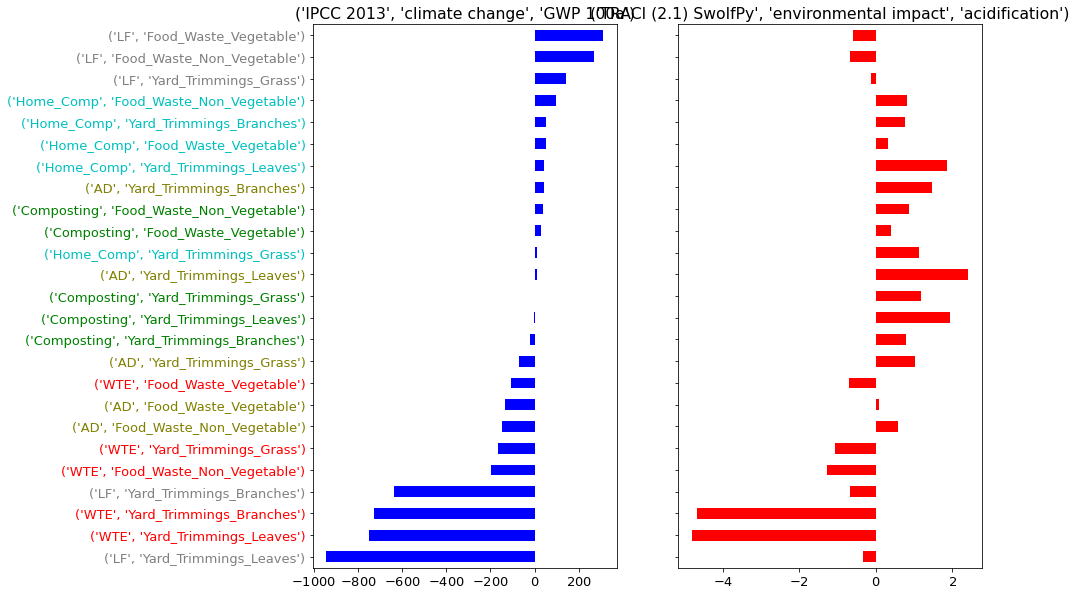

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,10), sharey=True)
impacts.iloc[:, 0].plot(kind='barh', ax=ax1, color='b', title=impacts.columns[0])
impacts.iloc[:, 1].plot(kind='barh', ax=ax2, color='r', title=impacts.columns[1])

def set_ticklablecolor (ax):
    for i in ax.get_yticklabels():
        if 'WTE' in str(i):
            i.set_color('r')
        elif 'AD' in str(i):
            i.set_color('olive')
        elif 'Composting' in str(i):
            i.set_color('g')
        elif 'Home_Comp' in str(i):
            i.set_color('c')
        elif 'LF' in str(i):
            i.set_color('gray')
set_ticklablecolor(ax1)

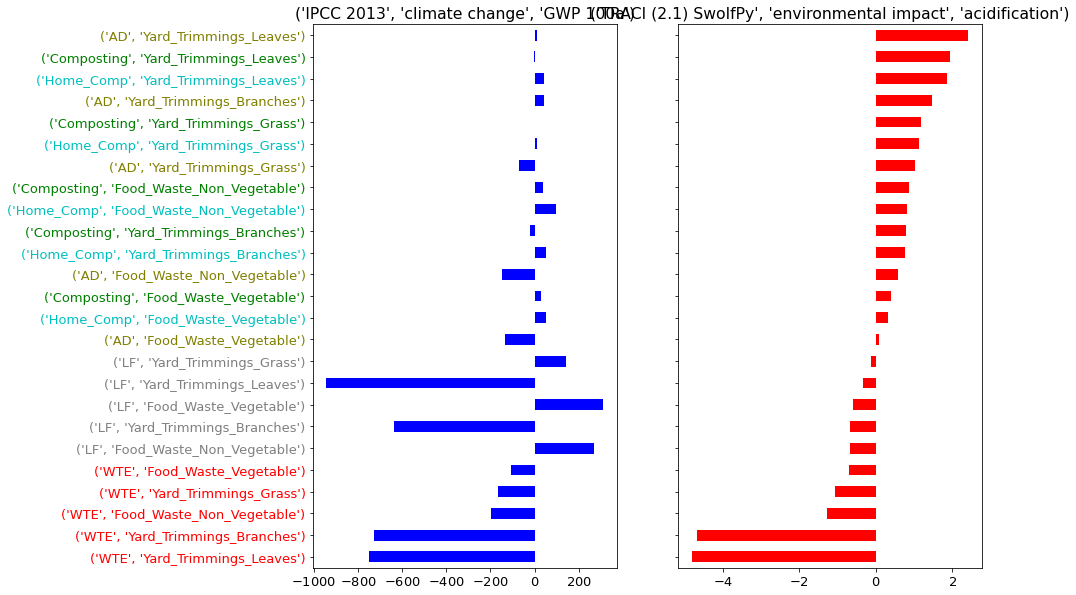

In [29]:
impacts.sort_values(by=impacts.columns[1], inplace=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,10), sharey=True)
impacts.iloc[:, 0].plot(kind='barh', ax=ax1, color='b', title=impacts.columns[0])
impacts.iloc[:, 1].plot(kind='barh', ax=ax2, color='r', title=impacts.columns[1])

def set_ticklablecolor (ax):
    for i in ax.get_yticklabels():
        if 'WTE' in str(i):
            i.set_color('r')
        elif 'AD' in str(i):
            i.set_color('olive')
        elif 'Composting' in str(i):
            i.set_color('g')
        elif 'Home_Comp' in str(i):
            i.set_color('c')
        elif 'LF' in str(i):
            i.set_color('gray')
set_ticklablecolor(ax1)

## Leaves

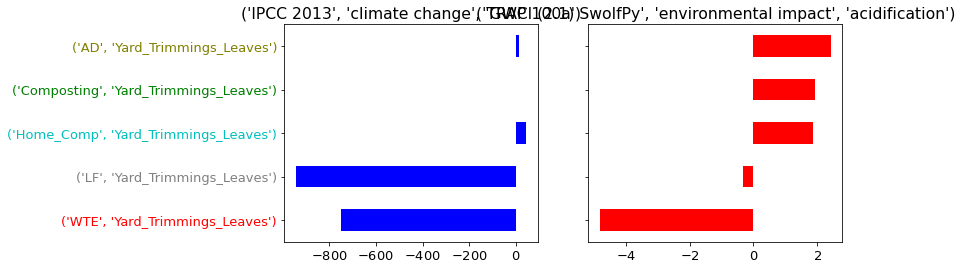

In [30]:
# Leaves
subset_impacts = impacts.loc[['Yard_Trimmings_Leaves' in str(x) for x in impacts.index],:]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey=True)
subset_impacts.iloc[:, 0].plot(kind='barh', ax=ax1, color='b', title=subset_impacts.columns[0])
subset_impacts.iloc[:, 1].plot(kind='barh', ax=ax2, color='r', title=subset_impacts.columns[1])
set_ticklablecolor(ax1)

## Branches

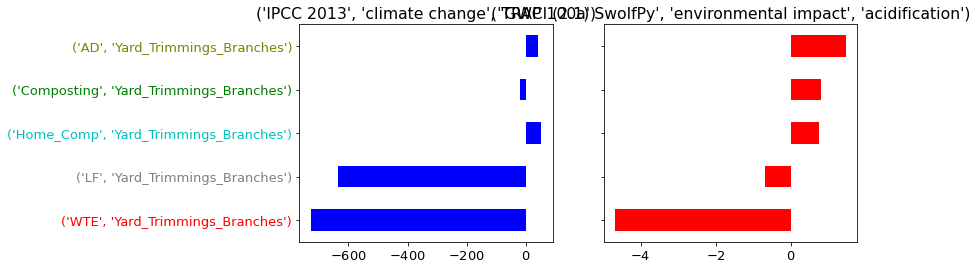

In [31]:
# Branches
subset_impacts = impacts.loc[['Yard_Trimmings_Branches' in str(x) for x in impacts.index],:]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey=True)
subset_impacts.iloc[:, 0].plot(kind='barh', ax=ax1, color='b', title=subset_impacts.columns[0])
subset_impacts.iloc[:, 1].plot(kind='barh', ax=ax2, color='r', title=subset_impacts.columns[1])
set_ticklablecolor(ax1)

## Grass

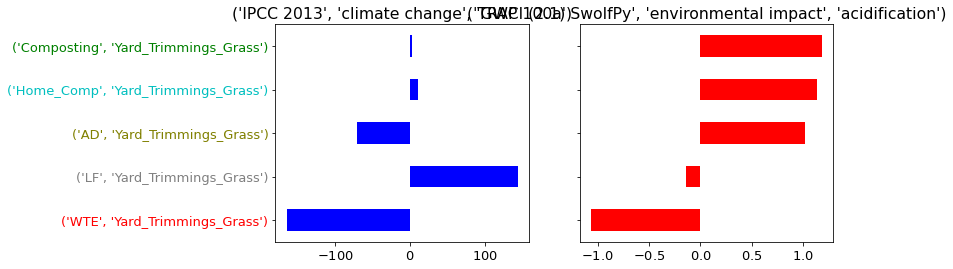

In [32]:
# Grass
subset_impacts = impacts.loc[['Yard_Trimmings_Grass' in str(x) for x in impacts.index],:]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey=True)
subset_impacts.iloc[:, 0].plot(kind='barh', ax=ax1, color='b', title=subset_impacts.columns[0])
subset_impacts.iloc[:, 1].plot(kind='barh', ax=ax2, color='r', title=subset_impacts.columns[1])
set_ticklablecolor(ax1)

## FW Veg

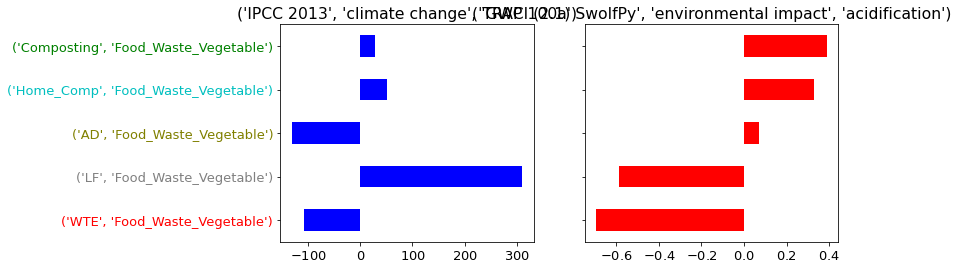

In [33]:
# FW Veg
subset_impacts = impacts.loc[['Food_Waste_Vegetable' in str(x) for x in impacts.index],:]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey=True)
subset_impacts.iloc[:, 0].plot(kind='barh', ax=ax1, color='b', title=subset_impacts.columns[0])
subset_impacts.iloc[:, 1].plot(kind='barh', ax=ax2, color='r', title=subset_impacts.columns[1])
set_ticklablecolor(ax1)

## FW Non Veg

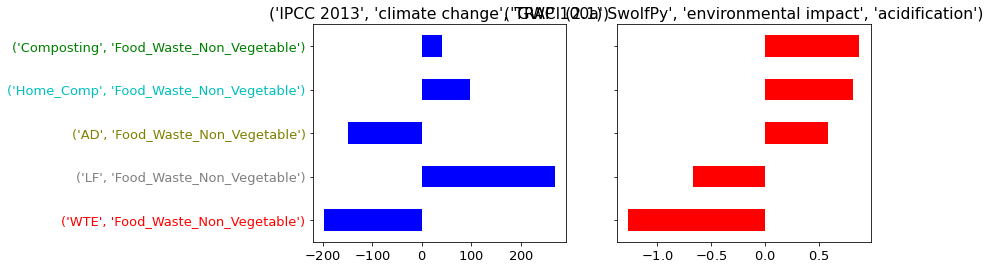

In [34]:
# FW Non Veg
subset_impacts = impacts.loc[['Food_Waste_Non_Vegetable' in str(x) for x in impacts.index],:]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey=True)
subset_impacts.iloc[:, 0].plot(kind='barh', ax=ax1, color='b', title=subset_impacts.columns[0])
subset_impacts.iloc[:, 1].plot(kind='barh', ax=ax2, color='r', title=subset_impacts.columns[1])
set_ticklablecolor(ax1)